In [3]:
# Author: Kaylani Bochie
# github.com/kaylani2
# kaylani AT gta DOT ufrj DOT br

### K: Model: Kmeans
import sys
import time
import pandas as pd
import os
import math
sys.path.insert(1, '../')
import numpy as np
from numpy import mean, std
from matplotlib import pyplot as plt
from unit import remove_columns_with_one_value, remove_nan_columns, load_dataset
from unit import display_general_information, display_feature_distribution
from collections import Counter
#from imblearn.over_sampling import RandomOverSampler, RandomUnderSampler
import sklearn
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import keras.utils
from keras import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM
from keras.optimizers import RMSprop, Adam
from keras.constraints import maxnorm


###############################################################################
## Define constants
###############################################################################
pd.set_option ('display.max_rows', None)
pd.set_option ('display.max_columns', 5)
BOT_IOT_DIRECTORY = '../../../../../datasets/bot-iot/'
BOT_IOT_FEATURE_NAMES = 'UNSW_2018_IoT_Botnet_Dataset_Feature_Names.csv'
BOT_IOT_FILE_5_PERCENT_SCHEMA = 'UNSW_2018_IoT_Botnet_Full5pc_{}.csv' # 1 - 4
FIVE_PERCENT_FILES = 4
BOT_IOT_FILE_FULL_SCHEMA = 'UNSW_2018_IoT_Botnet_Dataset_{}.csv' # 1 - 74
FULL_FILES = 74
FILE_NAME = BOT_IOT_DIRECTORY + BOT_IOT_FILE_5_PERCENT_SCHEMA
FEATURES = BOT_IOT_DIRECTORY + BOT_IOT_FEATURE_NAMES
NAN_VALUES = ['?', '.']
TARGET = 'attack'
INDEX_COLUMN = 'pkSeqID'
LABELS = ['attack', 'category', 'subcategory']
STATE = 0
try:
  STATE = int (sys.argv [1])
except:
  pass
#for STATE in [1, 2, 3, 4, 5]:
np.random.seed (STATE)
print ('STATE:', STATE)


###############################################################################
## Load dataset
###############################################################################
df = load_dataset (FILE_NAME, FIVE_PERCENT_FILES, INDEX_COLUMN, NAN_VALUES)


###############################################################################
## Clean dataset
###############################################################################
###############################################################################
### Remove columns with only one value
df, log = remove_columns_with_one_value (df, verbose = False)
print (log)


###############################################################################
### Remove redundant columns, useless columns and unused targets
### K: _number columns are numerical representations of other existing columns.
### K: category and subcategory are other labels.
### K: saddr and daddr may specialize the model to a single network
redundant_columns = ['state_number', 'proto_number', 'flgs_number']
other_targets = ['category', 'subcategory']
misc_columns = ['saddr', 'daddr']
print ('Removing redundant columns:', redundant_columns)
print ('Removing useless targets:', other_targets)
print ('Removing misc columns:', misc_columns)
columns_to_remove = redundant_columns + other_targets + misc_columns
df.drop (axis = 'columns', columns = columns_to_remove, inplace = True)

###############################################################################
### Remove NaN columns (with a lot of NaN values)
df, log = remove_nan_columns (df, 1/2, verbose = False)
print (log)

###############################################################################
### Encode categorical features
print ('Encoding categorical features (ordinal encoding).')
my_encoder = OrdinalEncoder ()
df ['flgs'] = my_encoder.fit_transform (df ['flgs'].values.reshape (-1, 1))
df ['proto'] = my_encoder.fit_transform (df ['proto'].values.reshape (-1, 1))
df ['sport'] = my_encoder.fit_transform (df ['sport'].astype (str).values.reshape (-1, 1))
df ['dport'] = my_encoder.fit_transform (df ['dport'].astype (str).values.reshape (-1, 1))
df ['state'] = my_encoder.fit_transform (df ['state'].values.reshape (-1, 1))
print ('Objects:', list (df.select_dtypes ( ['object']).columns))


###############################################################################
## Quick sanity check
###############################################################################
display_general_information (df)


###############################################################################
## Split dataset into train and test sets
###############################################################################
### K: Dataset is too big? Drop.
# drop_indices = np.random.choice (df.index, int (df.shape [0] * 0.5),
#                                  replace = False)
# df = df.drop (drop_indices)
TEST_SIZE = 3/10
VALIDATION_SIZE = 1/4
print ('Splitting dataset (test/train):', TEST_SIZE)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split (
                                               df.loc [:, df.columns != TARGET],
                                               df [TARGET],
                                               test_size = TEST_SIZE,
                                               random_state = STATE,)
print ('Splitting dataset (validation/train):', VALIDATION_SIZE)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split (
                                             X_train_df,
                                             y_train_df,
                                             test_size = VALIDATION_SIZE,
                                             random_state = STATE,)
print ('X_train_df shape:', X_train_df.shape)
print ('y_train_df shape:', y_train_df.shape)
print ('X_val_df shape:', X_val_df.shape)
print ('y_val_df shape:', y_val_df.shape)
print ('X_test_df shape:', X_test_df.shape)
print ('y_test_df shape:', y_test_df.shape)


###############################################################################
## Convert dataframe to a numpy array
###############################################################################
print ('\nConverting dataframe to numpy array.')
X_train = X_train_df.values
y_train = y_train_df.values
X_val = X_val_df.values
y_val = y_val_df.values
X_test = X_test_df.values
y_test = y_test_df.values
print ('X_train shape:', X_train.shape)
print ('y_train shape:', y_train.shape)
print ('X_val shape:', X_val.shape)
print ('y_val shape:', y_val.shape)
print ('X_test shape:', X_test.shape)
print ('y_test shape:', y_test.shape)


###############################################################################
## Apply normalization
###############################################################################
### K: NOTE: Only use derived information from the train set to avoid leakage.
print ('\nApplying normalization.')
startTime = time.time ()
scaler = StandardScaler ()
#scaler = MinMaxScaler (feature_range = (0, 1))
scaler.fit (X_train)
X_train = scaler.transform (X_train)
X_val = scaler.transform (X_val)
X_test = scaler.transform (X_test)
print (str (time.time () - startTime), 'to normalize data.')

###############################################################################
## Perform feature selection
###############################################################################
#TODO


###############################################################################
## Create learning model (KMeans)
###############################################################################
###############################################################################



################################################################################
### Hyperparameter tuning
#test_fold = np.repeat ([-1, 0], [X_train.shape [0], X_val.shape [0]])
#myPreSplit = PredefinedSplit (test_fold)
#
#def create_model (learn_rate = 0.01, dropout_rate = 0.0, weight_constraint = 0,
#                  filter_size = 2):
#  model = Sequential ()
#  model.add (Conv2D (64, (filter_size, filter_size), activation = 'relu',
#                     input_shape = (SIZE, SIZE, 1),))
#  model.add (Conv2D (64, (filter_size, filter_size), activation = 'relu'))
#  model.add (MaxPooling2D ( (filter_size, filter_size)))
#  model.add (Flatten ())
#  model.add (Dense (64, activation = 'relu',))
#  model.add (Dropout (dropout_rate))
#  model.add (Dense (1, activation = 'sigmoid',))
#  model.compile (optimizer = Adam (lr = learn_rate),
#                 loss = 'binary_crossentropy',
#                 metrics = ['binary_accuracy'])#, metrics.Precision ()])
#  return model
#
#model = KerasClassifier (build_fn = create_model, verbose = 2)
#batch_size = [2000, 5000]#, 2000]#10, 30, 50]
#epochs = [5, 10]
#learn_rate = [0.001]#, 0.01]#, 0.1, 0.2]
#dropout_rate = [0.0, 0.2]#, 0.2]
#weight_constraint = [0]#, 2, 3, 4, 5]
#filter_size = [2]#, 3]
## batch_size = [100, 1000, 2048, 3200]
## epochs = [5, 20, 50, 100]
## lr = [1e-3, 1e-2, 1e-1, 2e-1]
## dropout_rate = [0.0, 0.2, 0.3]
#param_grid = dict (batch_size = batch_size, epochs = epochs,
#                   dropout_rate = dropout_rate, learn_rate = learn_rate,
#                   weight_constraint = weight_constraint,
#                   filter_size = filter_size)
#grid = GridSearchCV (estimator = model, param_grid = param_grid,
#                     scoring = 'f1_weighted', cv = myPreSplit, verbose = 2,
#                     n_jobs = -1)
#
#grid_result = grid.fit (np.concatenate ( (X_train, X_val), axis = 0),
#                        np.concatenate ( (y_train, y_val), axis = 0))
#print (grid_result.best_params_)
#
#print ("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip (means, stds, params):
#  print ("%f (%f) with: %r" % (mean, stdev, param))

#sys.exit ()

STATE: 0
Reading ../../../../../datasets/bot-iot/UNSW_2018_IoT_Botnet_Full5pc_1.csv
Reading ../../../../../datasets/bot-iot/UNSW_2018_IoT_Botnet_Full5pc_2.csv
Reading ../../../../../datasets/bot-iot/UNSW_2018_IoT_Botnet_Full5pc_3.csv
Reading ../../../../../datasets/bot-iot/UNSW_2018_IoT_Botnet_Full5pc_4.csv
While removing single value columns: No columns dropped.
Removing redundant columns: ['state_number', 'proto_number', 'flgs_number']
Removing useless targets: ['category', 'subcategory']
Removing misc columns: ['saddr', 'daddr']
While removing nan value columns: No columns dropped.
Encoding categorical features (ordinal encoding).
Objects: []
Dataframe shape (lines, columns): (3668522, 38) 

First 5 entries:
                 stime  flgs  ...  Pkts_P_State_P_Protocol_P_SrcIP  attack
pkSeqID                      ...                                         
1        1.528089e+09   0.0  ...                              602       1
2        1.528089e+09   0.0  ...                        

In [ ]:
from matplotlib import pyplot as plt
###############################################################################
## Finished model
wcss = []
for k in range (1, 21):
    clf = KMeans (n_clusters = k, n_init = 10, max_iter = 500, random_state = STATE)


    ###############################################################################
    ## Fit the model
    ###############################################################################
    print ('\nFitting the model.')
    startTime = time.time ()
    clf.fit (X_train)
    print (str (time.time () - startTime), 's to train model.')
    wcss.append(clf.inertia_)
    

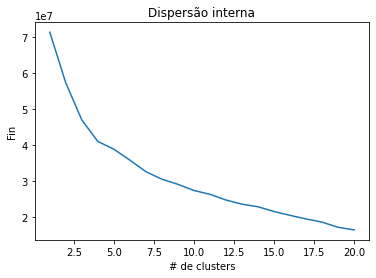

[71261001.00000072, 57165841.129051246, 46872956.10025393, 40898509.82409307, 38751787.222792216, 35711206.05373253, 32500541.439961746, 30419188.62998078, 28986193.33050985, 27274825.823740378, 26215836.7003258, 24617148.266726438, 23473992.1107581, 22748637.118819073, 21431440.094797827, 20362120.151470754, 19366219.808920287, 18475961.207961045, 17033055.403899156, 16316621.533583974]


In [15]:
plt.plot(range(1, 21), wcss)
plt.title('Dispersão interna')
plt.xlabel('# de clusters')
plt.ylabel('Fin')
plt.show()
print (wcss)

In [ ]:
###############################################################################
## Analyze results
###############################################################################
print ('\nPerformance on TRAIN set:')
clusters = clf.predict(X_train)

In [9]:
print (len (clusters))
print (clf.inertia_)

1925973
57165841.129051246


In [ ]:
y_pred = clf.predict (X_train)
y_pred = y_pred.round ()
my_confusion_matrix = confusion_matrix (y_train, y_pred,
                                        labels = df [TARGET].unique ())
tn, fp, fn, tp = my_confusion_matrix.ravel ()
print ('Confusion matrix:')
print (my_confusion_matrix)
print ('Accuracy:', accuracy_score (y_train, y_pred))
print ('Precision:', precision_score (y_train, y_pred, average = 'macro'))
print ('Recall:', recall_score (y_train, y_pred, average = 'macro'))
print ('F1:', f1_score (y_train, y_pred, average = 'macro'))
print ('Cohen Kappa:', cohen_kappa_score (y_train, y_pred,
                       labels = df [TARGET].unique ()))
print ('TP:', tp)
print ('TN:', tn)
print ('FP:', fp)
print ('FN:', fn)
sys.exit ()

### K: Only before publishing... Don't peek.
print ('\nPerformance on TEST set:')
y_pred = clf.predict (X_test)
y_pred = y_pred.round ()
my_confusion_matrix = confusion_matrix (y_test, y_pred,
                                        labels = df [TARGET].unique ())
tn, fp, fn, tp = my_confusion_matrix.ravel ()
print ('Confusion matrix:')
print (my_confusion_matrix)
print ('Accuracy:', accuracy_score (y_test, y_pred))
print ('Precision:', precision_score (y_test, y_pred, average = 'macro'))
print ('Recall:', recall_score (y_test, y_pred, average = 'macro'))
print ('F1:', f1_score (y_test, y_pred, average = 'macro'))
print ('Cohen Kappa:', cohen_kappa_score (y_test, y_pred,
                       labels = df [TARGET].unique ()))
print ('TP:', tp)
print ('TN:', tn)
print ('FP:', fp)
print ('FN:', fn)